In [1]:
#Gene Set Enrichment Analysis using Fisher Exact Test

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import pickle
import seaborn as sns
from scipy.stats import fisher_exact
import gseapy as gp

In [ ]:
#Read in the required data

In [3]:
datExpr = pd.read_csv('/data/recode/mic_datExpr_pseudobulk.csv', index_col = 0)

In [4]:
with open('/data/recode/separated_communities.pkl', 'rb') as file:
        separated_communities = pickle.load(file)

In [5]:
# Convert each module in separated_communities to a set
modules = {f'Module_{i+1}': set(community) for i, community in enumerate(separated_communities)}

In [6]:
modules

{'Module_1': {'ABCB4',
  'ABCC5',
  'ABHD3',
  'ACO1',
  'ACSF2',
  'ACSL4',
  'ADAMTSL2',
  'ADCY9',
  'ADGRB3',
  'ADGRG5',
  'AGBL4',
  'AHNAK',
  'AIDA',
  'AIF1',
  'AK5',
  'ALCAM',
  'ALOX15B',
  'AMN1',
  'AMPD3',
  'ANKMY1',
  'ANKRD26',
  'ANO6',
  'APEX2',
  'APMAP',
  'APOC1',
  'APOE',
  'APOLD1',
  'ARHGAP11A',
  'ARHGAP29',
  'ARHGAP6',
  'ARHGEF11',
  'ARL14EP',
  'ARNT',
  'ASB14',
  'ASIC2',
  'ASPM',
  'ATAD2',
  'ATG4C',
  'ATP1B3',
  'ATXN7',
  'AUH',
  'AURKB',
  'AZGP1',
  'BAG2',
  'BANF2',
  'BCAR3',
  'BCKDHB',
  'BCO2',
  'BHMT2',
  'BIVM',
  'BMPR1A',
  'BNIP3L',
  'BRCA2',
  'BRICD5',
  'BTBD17',
  'BTG1',
  'BUB1',
  'C12orf42',
  'C1orf54',
  'C5orf34',
  'C7orf25',
  'CA8',
  'CACNA1D',
  'CADM1',
  'CADM2',
  'CADPS',
  'CAMSAP2',
  'CAPS2',
  'CASP8',
  'CASS4',
  'CATSPERE',
  'CCDC121',
  'CCDC125',
  'CCDC146',
  'CCDC18',
  'CCDC30',
  'CCDC88B',
  'CD247',
  'CD86',
  'CD96',
  'CDK8',
  'CDR2',
  'CENPE',
  'CENPF',
  'CENPI',
  'CENPP',
  'CENPQ

In [7]:
# Step 1: Load the GMT file
def read_gmt_file(file_path):
    gene_sets = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            gene_set_name = parts[0]
            genes = parts[2:]
            gene_sets[gene_set_name] = set(genes)
    return gene_sets

In [8]:
gmt_file = 'h.all.v2023.2.Hs.symbols.gmt'
gene_sets = read_gmt_file(gmt_file)

In [9]:
gene_sets

{'HALLMARK_ADIPOGENESIS': {'ABCA1',
  'ABCB8',
  'ACAA2',
  'ACADL',
  'ACADM',
  'ACADS',
  'ACLY',
  'ACO2',
  'ACOX1',
  'ADCY6',
  'ADIG',
  'ADIPOQ',
  'ADIPOR2',
  'AGPAT3',
  'AIFM1',
  'AK2',
  'ALDH2',
  'ALDOA',
  'ANGPT1',
  'ANGPTL4',
  'APLP2',
  'APOE',
  'ARAF',
  'ARL4A',
  'ATL2',
  'ATP1B3',
  'ATP5PO',
  'BAZ2A',
  'BCKDHA',
  'BCL2L13',
  'BCL6',
  'C3',
  'CAT',
  'CAVIN1',
  'CAVIN2',
  'CCNG2',
  'CD151',
  'CD302',
  'CD36',
  'CDKN2C',
  'CHCHD10',
  'CHUK',
  'CIDEA',
  'CMBL',
  'CMPK1',
  'COL15A1',
  'COL4A1',
  'COQ3',
  'COQ5',
  'COQ9',
  'COX6A1',
  'COX7B',
  'COX8A',
  'CPT2',
  'CRAT',
  'CS',
  'CYC1',
  'CYP4B1',
  'DBT',
  'DDT',
  'DECR1',
  'DGAT1',
  'DHCR7',
  'DHRS7',
  'DHRS7B',
  'DLAT',
  'DLD',
  'DNAJB9',
  'DNAJC15',
  'DRAM2',
  'ECH1',
  'ECHS1',
  'ELMOD3',
  'ELOVL6',
  'ENPP2',
  'EPHX2',
  'ESRRA',
  'ESYT1',
  'ETFB',
  'FABP4',
  'FAH',
  'FZD4',
  'G3BP2',
  'GADD45A',
  'GBE1',
  'GHITM',
  'GPAM',
  'GPAT4',
  'GPD2',
  'GPHN

In [10]:
#Calculate Fisher's Exact Test for Enrichment

# Container for results
results = []

# Iterate over each module
for module_name, module_genes in modules.items():
    module_genes_in_expr = module_genes.intersection(datExpr.columns)
    
    # Check if module_genes_in_expr is empty to avoid issues
    if len(module_genes_in_expr) == 0:
        continue

    # Iterate over each gene set in the GMT file
    for gene_set_name, gene_set_genes in gene_sets.items():
        overlap_genes = module_genes_in_expr.intersection(gene_set_genes)
        non_overlap_module_genes = module_genes_in_expr.difference(gene_set_genes)
        non_overlap_gene_set_genes = gene_set_genes.difference(module_genes_in_expr)

        # Calculate the contingency table
        a = len(overlap_genes)
        b = len(non_overlap_module_genes)
        c = len(non_overlap_gene_set_genes)
        d = len(set(datExpr.columns)) - (a + b + c)  # Adjust d to only consider genes in datExpr
        
        # Ensure all values in the contingency table are non-negative
        if a < 0 or b < 0 or c < 0 or d < 0:
            continue

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='two-sided')
        
        results.append({
            'Module': module_name,
            'Gene Set': gene_set_name,
            'Overlap Count': a,
            'Odds Ratio': odds_ratio,
            'P-value': p_value
        })


In [11]:
# Convert results to DataFrame for further analysis
results_df = pd.DataFrame(results)

# Adjust p-values for multiple testing
results_df['Adjusted P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]

# Display results
print(results_df)

        Module                             Gene Set  Overlap Count  \
0     Module_1                HALLMARK_ADIPOGENESIS              6   
1     Module_1         HALLMARK_ALLOGRAFT_REJECTION             10   
2     Module_1           HALLMARK_ANDROGEN_RESPONSE              8   
3     Module_1                HALLMARK_ANGIOGENESIS              2   
4     Module_1             HALLMARK_APICAL_JUNCTION              7   
..         ...                                  ...            ...   
545  Module_11   HALLMARK_UNFOLDED_PROTEIN_RESPONSE              0   
546  Module_11              HALLMARK_UV_RESPONSE_DN              0   
547  Module_11              HALLMARK_UV_RESPONSE_UP              0   
548  Module_11  HALLMARK_WNT_BETA_CATENIN_SIGNALING              0   
549  Module_11       HALLMARK_XENOBIOTIC_METABOLISM              0   

     Odds Ratio       P-value  Adjusted P-value  
0      0.012964  1.206169e-75      9.477040e-74  
1      0.022597  1.019408e-68      3.504216e-67  
2      0.

In [12]:
#Let's focus on one module for the purpose of the enrichment analysis:
# Filter for Module 1 and sort by overlap count
module_1_results = results_df[results_df['Module'] == 'Module_1']
top_10_enriched_gene_sets = module_1_results.sort_values(by='Overlap Count', ascending=False).head(10)

print(top_10_enriched_gene_sets)

      Module                            Gene Set  Overlap Count  Odds Ratio  \
17  Module_1             HALLMARK_G2M_CHECKPOINT             17    0.041568   
12  Module_1                HALLMARK_E2F_TARGETS             14    0.033091   
29  Module_1            HALLMARK_MITOTIC_SPINDLE             13    0.030672   
46  Module_1             HALLMARK_UV_RESPONSE_DN             13    0.053366   
10  Module_1                 HALLMARK_COMPLEMENT             12    0.027732   
22  Module_1        HALLMARK_IL2_STAT5_SIGNALING             12    0.027996   
28  Module_1          HALLMARK_KRAS_SIGNALING_UP             11    0.025137   
21  Module_1                    HALLMARK_HYPOXIA             11    0.025137   
24  Module_1      HALLMARK_INFLAMMATORY_RESPONSE             11    0.025137   
26  Module_1  HALLMARK_INTERFERON_GAMMA_RESPONSE             11    0.025137   

         P-value  Adjusted P-value  
17  2.704290e-58      5.949439e-57  
12  1.512523e-62      3.466199e-61  
29  1.519644e-63   

In [13]:
#Extract data for plotting (top 10 pathways with highest overlap count)
top_10_enriched_gene_sets
y_labels = top_10_enriched_gene_sets['Gene Set']
x = top_10_enriched_gene_sets['Odds Ratio']
sizes = top_10_enriched_gene_sets['Overlap Count'] * 20
p_values = top_10_enriched_gene_sets['P-value']
adjusted_p_values = top_10_enriched_gene_sets['Adjusted P-value']

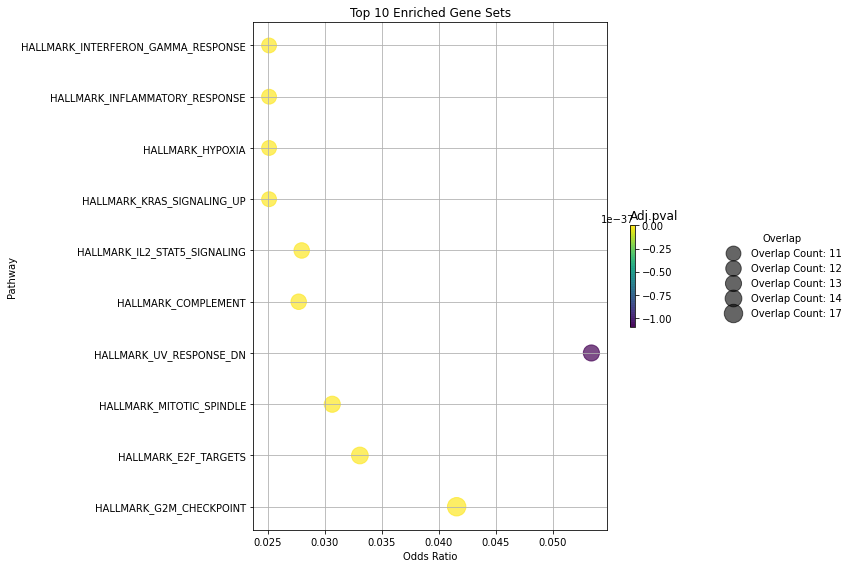

In [14]:
# Plot the scatter plot for the top 10 pathways
plt.figure(figsize=(12, 8))

# Main scatter plot
sc = plt.scatter(x, range(10), s=sizes, c=-adjusted_p_values, cmap='viridis', alpha=0.7)

# Set labels and title
plt.yticks(range(10), y_labels)  # Set y-axis labels to pathway names
plt.xlabel('Odds Ratio')
plt.ylabel('Pathway')
plt.title('Top 10 Enriched Gene Sets')

# Add a legend for dot sizes (overlap count) outside the plot
handles, labels = sc.legend_elements(prop="sizes", alpha=0.6)
legend_labels = [f'Overlap Count: {int(float(label.split("{")[1].split("}")[0]) // 20)}' for label in labels]
legend = plt.legend(handles, legend_labels, loc="center left", bbox_to_anchor=(1.3, 0.5), title="Overlap", frameon=False)

# Add colorbar
cbar = plt.colorbar(sc, shrink=0.2)  # Shrink colorbar size
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_title('Adj.pval', loc='left') 

# Adjust layout to prevent overlap between legends
plt.subplots_adjust(right=0.75)  # Adjust the right margin to make space for the legends

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [15]:
#KEGG pathway enrichment analysis using gseapy

In [16]:
kegg = gp.get_library(name='KEGG_2016', organism='Human')

In [17]:
kegg

{'Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate Homo sapiens hsa00532': ['CSGALNACT2',
  'CSGALNACT1',
  'CHST7',
  'CHPF2',
  'CHPF',
  'XYLT1',
  'B3GAT3',
  'XYLT2',
  'B3GALT6',
  'DSE',
  'UST',
  'CHST12',
  'CHSY3',
  'CHST13',
  'CHSY1',
  'CHST11',
  'CHST14',
  'CHST15',
  'B4GALT7',
  'CHST3'],
 'Glycosaminoglycan biosynthesis - heparan sulfate / heparin Homo sapiens hsa00534': ['HS3ST3A1',
  'HS3ST1',
  'HS3ST3B1',
  'XYLT1',
  'B3GAT3',
  'GLCE',
  'XYLT2',
  'B3GALT6',
  'HS6ST1',
  'HS6ST2',
  'HS3ST5',
  'HS2ST1',
  'HS6ST3',
  'HS3ST2',
  'EXT1',
  'NDST3',
  'EXT2',
  'EXTL1',
  'NDST2',
  'NDST1',
  'EXTL3',
  'EXTL2',
  'NDST4',
  'B4GALT7'],
 'Glycosylphosphatidylinositol(GPI)-anchor biosynthesis Homo sapiens hsa00563': ['GPLD1',
  'DPM2',
  'PIGC',
  'PIGF',
  'PIGB',
  'PIGA',
  'PIGL',
  'PIGK',
  'PIGN',
  'PIGM',
  'PIGH',
  'PIGG',
  'PIGT',
  'PIGS',
  'PGAP1',
  'PIGV',
  'PIGU',
  'PIGP',
  'PIGO',
  'PIGQ',
  'GPAA1',
  'PIGX',
 

In [18]:
gene_sets

{'HALLMARK_ADIPOGENESIS': {'ABCA1',
  'ABCB8',
  'ACAA2',
  'ACADL',
  'ACADM',
  'ACADS',
  'ACLY',
  'ACO2',
  'ACOX1',
  'ADCY6',
  'ADIG',
  'ADIPOQ',
  'ADIPOR2',
  'AGPAT3',
  'AIFM1',
  'AK2',
  'ALDH2',
  'ALDOA',
  'ANGPT1',
  'ANGPTL4',
  'APLP2',
  'APOE',
  'ARAF',
  'ARL4A',
  'ATL2',
  'ATP1B3',
  'ATP5PO',
  'BAZ2A',
  'BCKDHA',
  'BCL2L13',
  'BCL6',
  'C3',
  'CAT',
  'CAVIN1',
  'CAVIN2',
  'CCNG2',
  'CD151',
  'CD302',
  'CD36',
  'CDKN2C',
  'CHCHD10',
  'CHUK',
  'CIDEA',
  'CMBL',
  'CMPK1',
  'COL15A1',
  'COL4A1',
  'COQ3',
  'COQ5',
  'COQ9',
  'COX6A1',
  'COX7B',
  'COX8A',
  'CPT2',
  'CRAT',
  'CS',
  'CYC1',
  'CYP4B1',
  'DBT',
  'DDT',
  'DECR1',
  'DGAT1',
  'DHCR7',
  'DHRS7',
  'DHRS7B',
  'DLAT',
  'DLD',
  'DNAJB9',
  'DNAJC15',
  'DRAM2',
  'ECH1',
  'ECHS1',
  'ELMOD3',
  'ELOVL6',
  'ENPP2',
  'EPHX2',
  'ESRRA',
  'ESYT1',
  'ETFB',
  'FABP4',
  'FAH',
  'FZD4',
  'G3BP2',
  'GADD45A',
  'GBE1',
  'GHITM',
  'GPAM',
  'GPAT4',
  'GPD2',
  'GPHN

In [19]:
# Initialize an empty dictionary to store pathway name: gene names pairs
pathway_dict = {}

# Iterate through the pathway_gene_dict and populate the pathway_dict
for pathway_name, gene_list in kegg.items():
    # Convert gene list to a set to remove duplicates
    gene_set = set(gene_list)
    # Assign gene set to pathway name in pathway_dict
    pathway_dict[pathway_name] = gene_set

# Display the resulting dictionary
print(pathway_dict)

{'Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate Homo sapiens hsa00532': {'XYLT1', 'CHST13', 'CHSY1', 'XYLT2', 'CHST12', 'CHSY3', 'B3GALT6', 'CHST3', 'CSGALNACT2', 'CSGALNACT1', 'CHST15', 'B4GALT7', 'CHST11', 'CHPF2', 'CHPF', 'CHST14', 'B3GAT3', 'CHST7', 'DSE', 'UST'}, 'Glycosaminoglycan biosynthesis - heparan sulfate / heparin Homo sapiens hsa00534': {'XYLT1', 'HS3ST1', 'HS6ST3', 'HS3ST3B1', 'EXTL3', 'XYLT2', 'HS3ST2', 'NDST4', 'HS2ST1', 'B3GALT6', 'NDST1', 'B4GALT7', 'NDST3', 'HS6ST2', 'HS3ST5', 'EXTL2', 'EXT1', 'EXTL1', 'EXT2', 'B3GAT3', 'NDST2', 'GLCE', 'HS3ST3A1', 'HS6ST1'}, 'Glycosylphosphatidylinositol(GPI)-anchor biosynthesis Homo sapiens hsa00563': {'PIGF', 'PIGG', 'PIGT', 'PIGN', 'GPAA1', 'PIGL', 'PIGH', 'PIGV', 'PIGM', 'GPLD1', 'PIGC', 'PIGW', 'PIGK', 'PIGU', 'PIGO', 'PGAP1', 'PIGS', 'PIGP', 'PIGY', 'PIGX', 'PIGA', 'DPM2', 'PIGB', 'PIGZ', 'PIGQ'}, 'Steroid biosynthesis Homo sapiens hsa00100': {'MSMO1', 'DHCR24', 'SC5D', 'SQLE', 'NSDHL', 'CYP24A1', 'S

In [20]:
# Container for results
results = []

# Iterate over each module
for module_name, module_genes in modules.items():
    module_genes_in_expr = module_genes.intersection(datExpr.columns)
    
    # Check if module_genes_in_expr is empty to avoid issues
    if len(module_genes_in_expr) == 0:
        continue

    # Iterate over each gene set in the GMT file
    for gene_set_name, gene_set_genes in pathway_dict.items():
        overlap_genes = module_genes_in_expr.intersection(gene_set_genes)
        non_overlap_module_genes = module_genes_in_expr.difference(gene_set_genes)
        non_overlap_gene_set_genes = gene_set_genes.difference(module_genes_in_expr)

        # Calculate the contingency table
        a = len(overlap_genes)
        b = len(non_overlap_module_genes)
        c = len(non_overlap_gene_set_genes)
        d = len(set(datExpr.columns)) - (a + b + c)  # Adjust d to only consider genes in datExpr
        
        # Ensure all values in the contingency table are non-negative
        if a < 0 or b < 0 or c < 0 or d < 0:
            continue

         # Perform Fisher's exact test only if all values are non-negative
        contingency_table = [[a, b], [c, d]]
        odds_ratio = None
        if b * c != 0:
            odds_ratio = (a * d) / (b * c)
        
        results.append({
            'Module': module_name,
            'Gene Set': gene_set_name,
            'Overlap Count': a,
            'Odds Ratio': odds_ratio,
            'P-value': p_value
        })

In [21]:
# Convert results to DataFrame for further analysis
results_df = pd.DataFrame(results)

# Adjust p-values for multiple testing
results_df['Adjusted P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]

# Display results
print(results_df)

         Module                                           Gene Set  \
0      Module_1  Glycosaminoglycan biosynthesis - chondroitin s...   
1      Module_1  Glycosaminoglycan biosynthesis - heparan sulfa...   
2      Module_1  Glycosylphosphatidylinositol(GPI)-anchor biosy...   
3      Module_1         Steroid biosynthesis Homo sapiens hsa00100   
4      Module_1  SNARE interactions in vesicular transport Homo...   
...         ...                                                ...   
3207  Module_11    One carbon pool by folate Homo sapiens hsa00670   
3208  Module_11          Sulfur relay system Homo sapiens hsa04122   
3209  Module_11            Sulfur metabolism Homo sapiens hsa00920   
3210  Module_11    Selenocompound metabolism Homo sapiens hsa00450   
3211  Module_11  Aminoacyl-tRNA biosynthesis Homo sapiens hsa00970   

      Overlap Count  Odds Ratio  P-value  Adjusted P-value  
0                 3    0.128767      1.0               1.0  
1                 1    0.031154      

In [22]:
# Filter for Module 1 and sort by overlap count
module_1_results = results_df[results_df['Module'] == 'Module_1']
top_10_enriched_gene_sets = module_1_results.sort_values(by='Overlap Count', ascending=False).head(10)

print(top_10_enriched_gene_sets)

       Module                                           Gene Set  \
136  Module_1           Pathways in cancer Homo sapiens hsa05200   
130  Module_1        Ras signaling pathway Homo sapiens hsa04014   
129  Module_1       MAPK signaling pathway Homo sapiens hsa04010   
135  Module_1   PI3K-Akt signaling pathway Homo sapiens hsa04151   
172  Module_1                  Endocytosis Homo sapiens hsa04144   
23   Module_1                    Phagosome Homo sapiens hsa04145   
62   Module_1   cGMP-PKG signaling pathway Homo sapiens hsa04022   
105  Module_1  Natural killer cell mediated cytotoxicity Homo...   
45   Module_1  Cytokine-cytokine receptor interaction Homo sa...   
165  Module_1             HTLV-I infection Homo sapiens hsa05166   

     Overlap Count  Odds Ratio  P-value  Adjusted P-value  
136             24    0.006729      1.0               1.0  
130             15    0.027842      1.0               1.0  
129             15    0.021435      1.0               1.0  
135        

In [23]:
# Extract data for plotting (top 10 pathways with highest overlap count)
top_10_enriched_gene_sets
y_labels = top_10_enriched_gene_sets['Gene Set']
x = top_10_enriched_gene_sets['Odds Ratio']
sizes = top_10_enriched_gene_sets['Overlap Count'] * 20
p_values = top_10_enriched_gene_sets['P-value']
adjusted_p_values = top_10_enriched_gene_sets['Adjusted P-value']

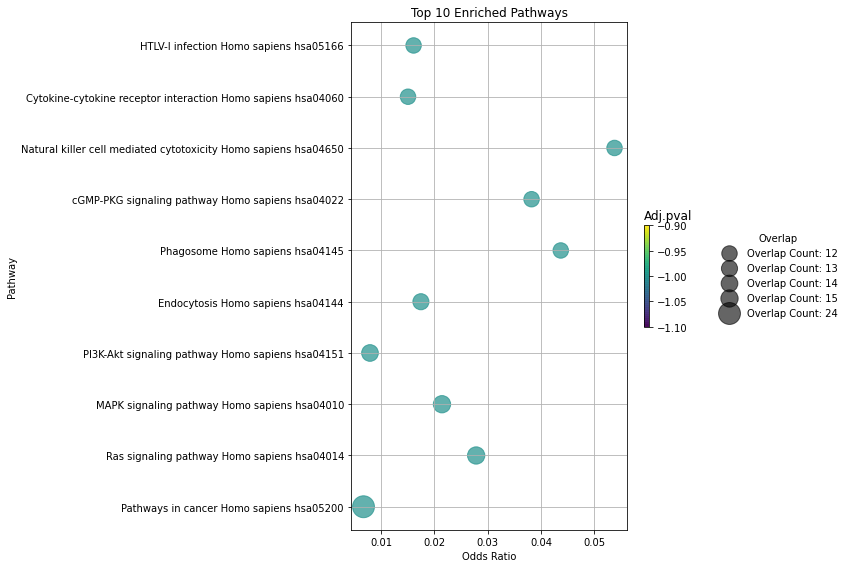

In [24]:
# Plot the scatter plot for the top 10 pathways
plt.figure(figsize=(12, 8))

# Main scatter plot
sc = plt.scatter(x, range(10), s=sizes, c=-adjusted_p_values, cmap='viridis', alpha=0.7)

# Set labels and title
plt.yticks(range(10), y_labels)  # Set y-axis labels to pathway names
plt.xlabel('Odds Ratio')
plt.ylabel('Pathway')
plt.title('Top 10 Enriched Pathways')

# Add a legend for dot sizes (overlap count) outside the plot
handles, labels = sc.legend_elements(prop="sizes", alpha=0.6)
legend_labels = [f'Overlap Count: {int(float(label.split("{")[1].split("}")[0]) // 20)}' for label in labels]
legend = plt.legend(handles, legend_labels, loc="center left", bbox_to_anchor=(1.3, 0.5), title="Overlap", frameon=False)

# Add colorbar
cbar = plt.colorbar(sc, shrink=0.2)  # Shrink colorbar size
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_title('Adj.pval', loc='left') 

# Adjust layout to prevent overlap between legends
plt.subplots_adjust(right=0.75)  # Adjust the right margin to make space for the legends

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
#Exercise Questions:
#1.What is gene set enrichment analysis?
#2.What is Fisher Exact Test?
#3.How does GSEA differ from use of Fisher Exact Test?

In [ ]:
#Answers
#1.GSEA is a computational method used to determine whether predefined sets of genes (gene sets) exhibit statistically significant differences in their expression between two or more biological states or conditions.
#2.The Fisher Exact Test is a statistical significance test used to determine whether there are nonrandom associations between two categorical variables in a contingency table. 
#3.GSEA focuses on analysing the collective behavior of genes within gene sets to uncover biologically relevant pathways or functional modules.
#Whereas Fisher Exact Test assesses the significance of associations between individual genes or genomic features and phenotypic categories.
#GSEA assesses the enrichment of gene sets by comparing the distribution of genes within each set to the overall distribution of genes ranked based on a statistical metric (e.g., differential expression score). It uses a running sum statistic or similar approach to calculate an enrichment score for each gene set and assesses statistical significance based on permutation testing or other methods.
#Whereas Fisher Exact Test alculates the probability of obtaining the observed distribution of frequencies in a contingency table under the null hypothesis of independence between two categorical variables. It uses the hypergeometric distribution to compute the probability of obtaining as extreme or more extreme frequencies than the observed frequencies.